# KD-drzewa

## Narzędzie graficzne
### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

# Rozwiązanie
### Używane klasy
`Range` - prostokąt kd-drzewa lub przeszukiwania<br>
    1. `isContainedIn` - czy prostokąt zawiera się w podanym<br>
    2. `isPointInRange` - czy podany punkt zawiera się w prostokącie<br>
    3. `intersects` - czy dany prostokąt przecina się z danym (ze względu na strukture drzewa kd przyjmuje się, że prostokąt kd-drzewa nie zawiera lewego i górnego brzegu)<br>
    4. `returnSplit` - na podstawie danej linii przecięcia zwróć prostokąt nią przecięty<br>
    
`leafNode` - liść KD-drzewa - przechowuje jeden punkt (klasę tę można pominąć, jednak pozwala lepiej zwizualizować KD-drzewo)<br>

`Node` - węzeł (nie liść) KD-drzewa - przechowuje współrzędną przeciecia oraz wskaźniki na kolejne węzły<br>

`KDTree` - struktura KD-drzewa<br>
    1. `init` - inicjalizuje na bazie zbioru punktów oblicza:<br>
        1. `maxRange` - maksymalny prostokąt KD-drzewa<br>
        2. `self.kdTreeRoot` - korzeń KD-drzewa <br>
    2. `__initAux` - rekurencyjna funkcja tworząca węzeł KD-drzewa<br>
    3. `__split` - pomocnicza funkcja dzieląca dane posortowane wg współrzędnych listy, znajduje mediane i dzieli je wg niej (O(n))<br>
    4. `__findMaxRange` - znalezienie wartości atrybutu `maxRange`<br>
    5. `printTree` - wypisanie drzewa (In order)<br>
    6. `search` - przeszukiwanie KD-drzewa<br>
    7. `__reportSubtree` - pomocnicza funkcja wypisująca wszsytkie punkty pod danym węzłem<br>

In [3]:
%matplotlib notebook

class Range:
    def __init__(self, x1, x2, y1, y2):
        assert x1 <= x2 and y1 <= y2, "Points were inserted wrong way around"
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2

    def isContainedIn(self, other):
        return other.x1 < self.x1 and self.x2 <= other.x2 \
               and other.y1 < self.y1 and self.y2 <= other.y2

    def isPointInRange(self, point):
        x, y = point
        return self.x1 <= x <= self.x2 and self.y1 <= y <= self.y2

    def intersects(self, other):  # self - nodeRange (open left and upper bound), other - searchRange (closed range)
        return (self.x1 < other.x2 and other.x1 <= self.x2) and \
               (self.y1 < other.y2 and other.y1 <= self.y2)

    def returnSplit(self, axis, side, line):
        result = Range(self.x1, self.x2, self.y1, self.y2)
        if axis == 0:  # x axis
            if side == "left":
                result.x2 = line
            elif side == "right":
                result.x1 = line
        elif axis == 1:  # y axis
            if side == "left":
                result.y2 = line
            elif side == "right":
                result.y1 = line

        assert result != self, "input range is the same as output"
        assert result.x1 <= result.x2 and result.y1 <= result.y2, "Split is invalid"

        return result


class LeafNode:
    def __init__(self, point):
        self.point = point


class Node:
    def __init__(self, splitCoord, left, right):
        self.splitCoord = splitCoord
        self.left = left
        self.right = right


class KDTree:
    def __init__(self, points):
        pointsXSorted = sorted(points, key=lambda x: x[0])
        pointsYSorted = sorted(points, key=lambda x: x[1])
        self.maxRange = self.__findMaxRange(pointsXSorted, pointsYSorted)
        self.kdTreeRoot = self.__initAux(pointsXSorted, pointsYSorted)

    def __initAux(self, pointsXSorted, pointsYSorted, depth=0):
        axis = depth % 2

        if len(pointsXSorted) == 1:
            singleton = pointsXSorted[0]  # in this case same as pointsYSorted
            return LeafNode(singleton)

        leftXSorted, rightXSorted, leftYSorted, rightYSorted, splitLine = self.__split(pointsXSorted, pointsYSorted, axis)
        return Node(splitLine,
                    self.__initAux(leftXSorted, leftYSorted, depth + 1),
                    self.__initAux(rightXSorted, rightYSorted, depth + 1))

    def __split(self, x_sorted, y_sorted, axis):
        arrWithMedian = x_sorted if axis == 0 else y_sorted
        otherArr = y_sorted if axis == 0 else x_sorted

        med_ind = (len(arrWithMedian)-1) // 2
        leftArr1, rightArr1 = arrWithMedian[:med_ind+1], arrWithMedian[med_ind+1:]
        # TODO change name of the array for something more suitable

        splitPointCoordinate = leftArr1[-1][axis]
        leftArr2 = list(filter(lambda x: x[axis] <= splitPointCoordinate, otherArr))
        rightArr2 = list(filter(lambda x: x[axis] > splitPointCoordinate, otherArr))

        if axis == 0:  # TODO simplify
            return leftArr1, rightArr1, leftArr2, rightArr2, splitPointCoordinate
        else:
            return leftArr2, rightArr2, leftArr1, rightArr2, splitPointCoordinate

    def __findMaxRange(self, pointsXSorted, pointsYSorted):
        min_x, max_x = pointsXSorted[0][0], pointsXSorted[-1][0]
        min_y, max_y = pointsYSorted[0][1], pointsYSorted[-1][1]
        return Range(min_x, max_x, min_y, max_y)

    def printTree(self, node, depth=0):
        if node.__class__ == LeafNode:
            print(node.point)
            return

        message = "x=" if depth % 2 == 0 else "y="

        self.printTree(node.left, depth + 1)
        print(message + str(node.splitCoord))
        self.printTree(node.right, depth + 1)

    def search(self, searchRange, node=None, nodeRange=None, depth=0):
        if node.__class__ == LeafNode:
            return [node.point] if searchRange.isPointInRange(node.point) else []

        if node is None:
            node = self.kdTreeRoot
            nodeRange = self.maxRange

        result = []

        leftChildRange = nodeRange.returnSplit(depth % 2, "left", node.splitCoord)
        rightChildRange = nodeRange.returnSplit(depth % 2, "right", node.splitCoord)

        if leftChildRange.isContainedIn(searchRange):
            result += self.__reportSubtree(node.left)
        elif leftChildRange.intersects(searchRange):
            result += self.search(searchRange, node.left, leftChildRange, depth+1)

        if rightChildRange.isContainedIn(searchRange):
            result += self.__reportSubtree(node.right)
        elif rightChildRange.intersects(searchRange):
            result += self.search(searchRange, node.right, rightChildRange, depth+1)

        return result

    def __reportSubtree(self, node):
        if node.__class__ == LeafNode:
            return [node.point]

        return self.__reportSubtree(node.left) + self.__reportSubtree(node.right)

In [4]:
points = [(3, 1), (1, 2), (6, 0), (7, 5), (4, 3)]
testTree = KDTree(points)

searchingRange = Range(2, 5, 0, 4)
print(testTree.search(searchingRange))

[(3, 1), (4, 3)]


### Wizualizator


In [16]:
class Visualizer:
    def __init__(self, setOfPoints):
        self.__colors = {"maxRange":"aquamarine",
                         "currentRange":"red",
                         "searchRange":"yellow",
                         "lines": "blue",
                         "reportedPoints": "fuchsia",
                         "currentPoints": "yellow",
                         "normalPoints": "teal"}
        self.setOfPoints = setOfPoints
        
        self.maxRange = None
        self.searchRange = None
        
        self.lines = []
        self.reportedPoints = []
        self.initScenes = [Scene(points=[PointsCollection(setOfPoints)])]  #first scene with only the initial points
        self.searchScenes = []
        
    
    def setMaxRange(self, maxRange):
        self.maxRange = maxRange
        
        
    def setSearchRange(self, searchRange):
        self.searchRange = searchRange
        
        
    def addLine(self, splitCoord, smallerBound, biggerBound, axis):
        if axis == 0:
            x, y1, y2 = splitCoord, smallerBound, biggerBound
            line = ((x, y1), (x, y2))
            
        elif axis == 1:
            y, x1, x2 = splitCoord, smallerBound, biggerBound
            line = ((x1, y), (x2, y))
        
        self.lines.append( line )
      
    
    def addPoint(self, point):
        self.reportedPoints.append(point)
        

    def _getRangeLines(self, rangeObj):
        if rangeObj is not None:
            p1 = (rangeObj.x1, rangeObj.y1)
            p2 = (rangeObj.x1, rangeObj.y2)
            p3 = (rangeObj.x2, rangeObj.y2)
            p4 = (rangeObj.x2, rangeObj.y1)
            return [(p1, p2), (p2, p3), (p3, p4), (p4, p1)]
        else:
            return []

    
    def makeScene(self, currPoints=None, currRange=None):
        if currPoints is None:
            currPoints = []
        
        points = [PointsCollection(self.setOfPoints[:], color = self.__colors["normalPoints"]),
                  PointsCollection(currPoints[:], color = self.__colors["currentPoints"]),
                  PointsCollection(self.reportedPoints[:], color = self.__colors["reportedPoints"])]
        lines = [LinesCollection(self._getRangeLines(self.maxRange), color=self.__colors["maxRange"]),
                 LinesCollection(self.lines[:], color=self.__colors["lines"]),
                LinesCollection(self._getRangeLines(self.searchRange), color=self.__colors["searchRange"]),
                LinesCollection(self._getRangeLines(currRange), color=self.__colors["currentRange"])]
        
        if currRange is None:
            self.initScenes.append(Scene(points, lines))
        else:
            self.searchScenes.append(Scene(points, lines))
            
            
    def getInitScenes(self):
        return self.initScenes
    
    def getSearchScenes(self):
        endScene = Scene([PointsCollection(self.setOfPoints[:], color = self.__colors["normalPoints"]),
                  PointsCollection(self.reportedPoints[:], color = self.__colors["reportedPoints"])],
                [LinesCollection(self._getRangeLines(self.searchRange), color=self.__colors["searchRange"])])
        self.searchScenes.append(endScene)
        
        return self.searchScenes
    
    
    def clear(self):   #after search so the lines don't collide
        self.searchRange = None
        self.reportedPoints = []
        self.searchScenes = []
        
    

In [17]:
class KDTreeVis:
    def __init__(self, points):
        pointsXSorted = sorted(points, key=lambda x: x[0])
        pointsYSorted = sorted(points, key=lambda x: x[1])
        self.vis = Visualizer(points)
        
        self.maxRange = self.__findMaxRange(pointsXSorted, pointsYSorted)
        self.vis.setMaxRange(self.maxRange)
        self.vis.makeScene(pointsXSorted)
        
        self.kdTreeRoot = self.__initAux(pointsXSorted, pointsYSorted)

        
    def __initAux(self, pointsXSorted, pointsYSorted, depth=0):
        axis = depth % 2

        otherAxis = (axis+1)%2
        smallerBound = min(pointsXSorted, key=lambda x: x[otherAxis])[otherAxis]
        biggerBound = max(pointsXSorted, key=lambda x: x[otherAxis])[otherAxis]
        
        if len(pointsXSorted) == 1:       # only one point in list
            singleton = pointsXSorted[0]  # in this case pointsXSorted is the same as pointsYSorted
            return LeafNode(singleton)

        leftXSorted, rightXSorted, leftYSorted, rightYSorted, splitLine = self.__split(pointsXSorted, pointsYSorted, axis)
        self.vis.addLine(splitLine, smallerBound, biggerBound, axis)
        self.vis.makeScene(pointsXSorted)
        
        return Node(splitLine,
                    self.__initAux(leftXSorted, leftYSorted, depth + 1),
                    self.__initAux(rightXSorted, rightYSorted, depth + 1))
    
    
    def __split(self, x_sorted, y_sorted, axis):
        arrWithMedian = x_sorted if axis == 0 else y_sorted
        otherArr = y_sorted if axis == 0 else x_sorted

        med_ind = (len(arrWithMedian)-1) // 2
        leftArr1, rightArr1 = arrWithMedian[:med_ind+1], arrWithMedian[med_ind+1:]
        # TODO change name of the array for something more suitable

        splitPointCoordinate = leftArr1[-1][axis]
        leftArr2 = list(filter(lambda x: x[axis] <= splitPointCoordinate, otherArr))
        rightArr2 = list(filter(lambda x: x[axis] > splitPointCoordinate, otherArr))

        if axis == 0:  # TODO simplify
            return leftArr1, rightArr1, leftArr2, rightArr2, splitPointCoordinate
        else:
            return leftArr2, rightArr2, leftArr1, rightArr2, splitPointCoordinate

        
    def __findMaxRange(self, pointsXSorted, pointsYSorted):
        min_x, max_x = pointsXSorted[0][0], pointsXSorted[-1][0]
        min_y, max_y = pointsYSorted[0][1], pointsYSorted[-1][1]
        return Range(min_x, max_x, min_y, max_y)
    
    
    def search(self, searchRange, node=None, nodeRange=None, depth=0):
        if node.__class__ == LeafNode:
            if searchRange.isPointInRange(node.point):
                self.vis.addPoint(node.point)
                self.vis.makeScene([node.point], nodeRange)
                return [node.point]
            else:
                return []

        if node is None:
            node = self.kdTreeRoot
            nodeRange = self.maxRange
            self.vis.setSearchRange(searchRange)
            self.vis.makeScene(currRange = self.maxRange)

        result = []

        leftChildRange = nodeRange.returnSplit(depth % 2, "left", node.splitCoord)
        rightChildRange = nodeRange.returnSplit(depth % 2, "right", node.splitCoord)

        self.vis.makeScene(currRange = leftChildRange)
        if leftChildRange.isContainedIn(searchRange):
            result += self.__reportSubtree(node.left)
        elif leftChildRange.intersects(searchRange):
            result += self.search(searchRange, node.left, leftChildRange, depth + 1)
        #self.vis.makeScene(currRange = leftChildRange)
        
        self.vis.makeScene(currRange = rightChildRange)
        if rightChildRange.isContainedIn(searchRange):
            result += self.__reportSubtree(node.right)
        elif rightChildRange.intersects(searchRange):
            result += self.search(searchRange,  node.right, rightChildRange, depth + 1)
        #self.vis.makeScene(currRange = rightChildRange)
        
        return result

    
    def __reportSubtree(self, node, visualizer):
        if node.__class__ == LeafNode:
            self.vis.addPoint(node.point)
            return [node.point]

        return self.__reportSubtree(node.left) + self.__reportSubtree(node.right)
    
    
    def getInitPlot(self):
        return Plot(scenes = self.vis.getInitScenes())
    
    def getSearchPlot(self):
        return Plot(scenes = self.vis.getSearchScenes())
    
    def clearVis(self):
        self.vis.clear()

<IPython.core.display.Javascript object>


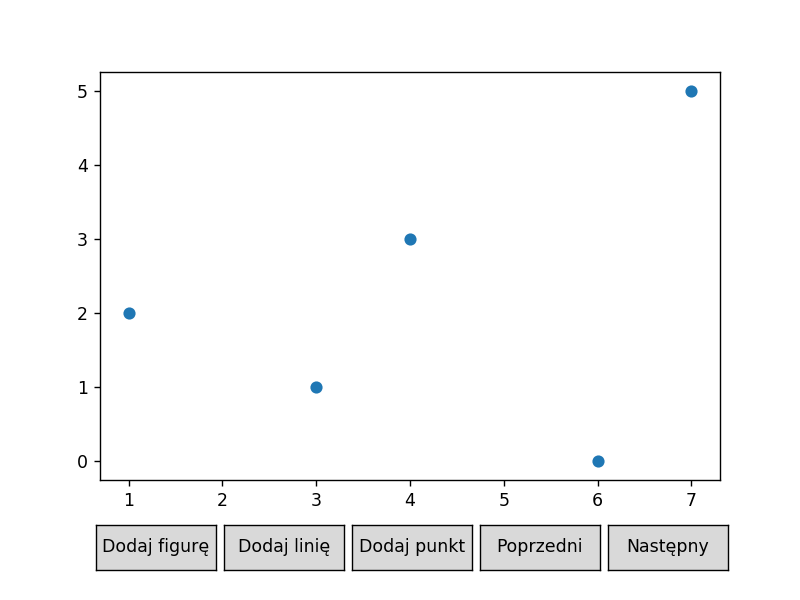

In [18]:
points = [(3, 1), (1, 2), (6, 0), (7, 5), (4, 3)]
testKDTreeVis = KDTreeVis(points)
searchingRange = Range(2, 5, 0, 4)

plot = testKDTreeVis.getInitPlot()
plot.draw()

<IPython.core.display.Javascript object>


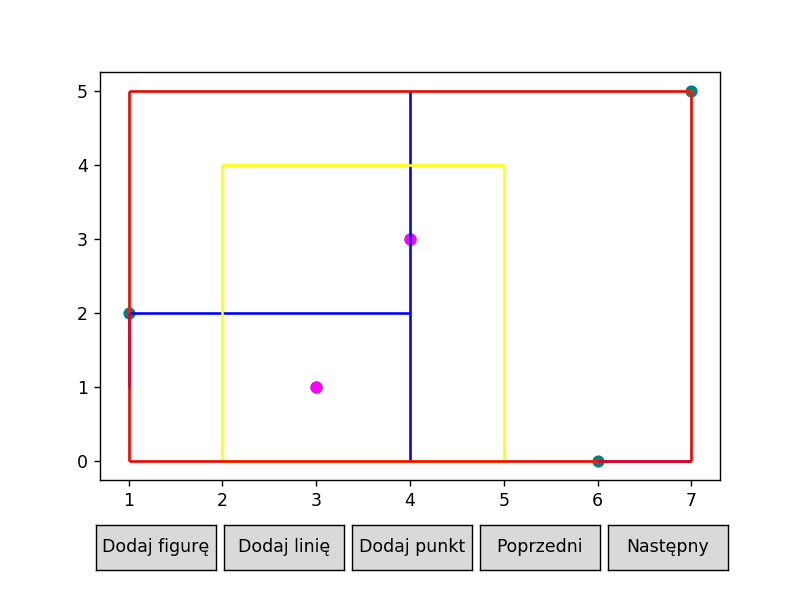

In [20]:
testKDTreeVis.search(searchingRange)
plot = testKDTreeVis.getSearchPlot()
plot.draw()
